In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import imgaug as ia
import os
import cv2
import random
import sklearn.utils
from imgaug import augmenters as iaa
from sklearn.model_selection import train_test_split
from skimage.io import imread
from keras.layers import Dropout, Flatten, Dense, Input, Concatenate
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Model, Sequential
from tensorflow import set_random_seed
from keras.optimizers import Adam
from keras.applications.nasnet import NASNetMobile


set_random_seed(123)


Using TensorFlow backend.


In [4]:
data = pd.read_csv("Histopathologic Cancer Detection/train_labels.csv")
train_path = "Histopathologic Cancer Detection/train"
test_path = "Histopathologic Cancer Detection/test"

data['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

In [9]:
# Lets augment the data with OpenCV
ORIGINAL_SIZE = 96

CROP_SIZE = 32              # size after cropping
RANDOM_ROTATION = 3         # range (0~180),  
RANDOM_BRIGHTNESS = 7       # range (0~100), 
RANDOM_CONTRAST = 5         # range (0~100), 
RANDOM_90_DEG_TURN = 1      # (0 or 1), random turn to left or right

shuffled_data = sklearn.utils.shuffle(data)

In [6]:
# Around 1.5 times more negatives than positives (60/40 %)
def read_bgr_to_rgb(path):
    path = str(path)
    bgr_img = cv2.imread(path)
    b, g, r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r, g, b])
    return rgb_img


In [7]:
def read_pre_processed_image(path):
    rgb_image = read_bgr_to_rgb(path)

    # Rotate
    rotation = random.randint(-RANDOM_ROTATION, RANDOM_ROTATION)
    if RANDOM_90_DEG_TURN == 1:
        rotation += random.randint(-1, 1) * 90
    rotation_matrix = cv2.getRotationMatrix2D(center=(ORIGINAL_SIZE/2, ORIGINAL_SIZE/2), angle=rotation, scale=1)
    rgb_image = cv2.warpAffine(src=rgb_image, M=rotation_matrix, dsize=(ORIGINAL_SIZE, ORIGINAL_SIZE))
    
    # Crop and normalize to 0-1 range
    start_crop: int = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_image = rgb_image[start_crop:end_crop, start_crop:end_crop] / 255

    # Flip
    flip_horizontal = bool(random.getrandbits(1))
    flip_vertical = bool(random.getrandbits(1))
    if flip_horizontal:
        rgb_image = rgb_image[:, ::-1]
    if flip_vertical:
        rgb_image = rgb_image[::-1, :]
        
    # Brightness
    brightness = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100
    rgb_image += brightness
    
    # Contrast
    contrast = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100
    rgb_image *= contrast
    
    # Clip
    rgb_image = np.clip(rgb_image, 0, 1.0)
    
    return rgb_image


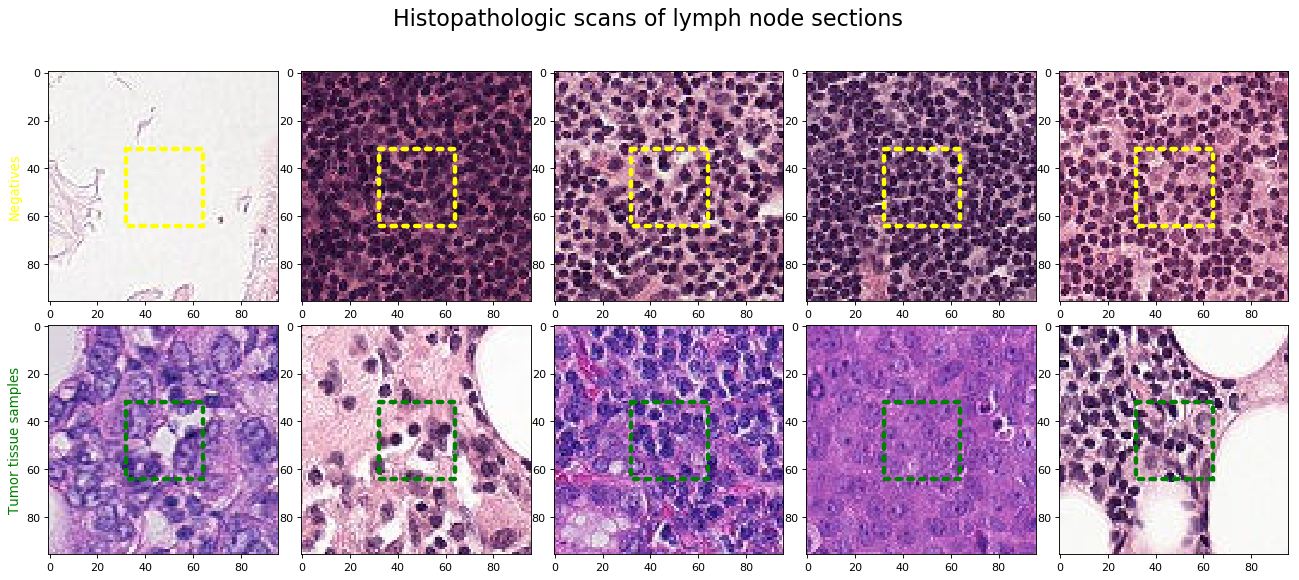

In [10]:
# Let's take a loot at the raw images
fig, ax = plt.subplots(nrows=2, ncols=5, dpi=80, figsize=(20, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

fig.suptitle('Histopathologic scans of lymph node sections', fontsize=20)

# Negatives
for i, index in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, index)
    ax[0, i].imshow(read_bgr_to_rgb(path + '.tif'));
    #  Create a rectangle patch
    box = patches.Rectangle(xy=(CROP_SIZE, CROP_SIZE), width=CROP_SIZE, height=CROP_SIZE, linewidth=4, edgecolor='yellow', facecolor='none',
                            linestyle=':', capstyle='round')
    ax[0, i].add_patch(box)
ax[0, 0].set_ylabel(ylabel='Negatives', size='large', color='yellow');

# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    
    path = os.path.join(train_path, idx)
    ax[1, i].imshow(read_bgr_to_rgb(path + '.tif'));
    # Create a Rectangle patch
    box = patches.Rectangle((CROP_SIZE, CROP_SIZE), CROP_SIZE, CROP_SIZE, linewidth=4,  edgecolor='green',
                            facecolor='none', linestyle=':', capstyle='round')
    ax[1, i].add_patch(box)
ax[1, 0].set_ylabel('Tumor tissue samples', size='large', color='green');

plt.savefig('fig1.png')

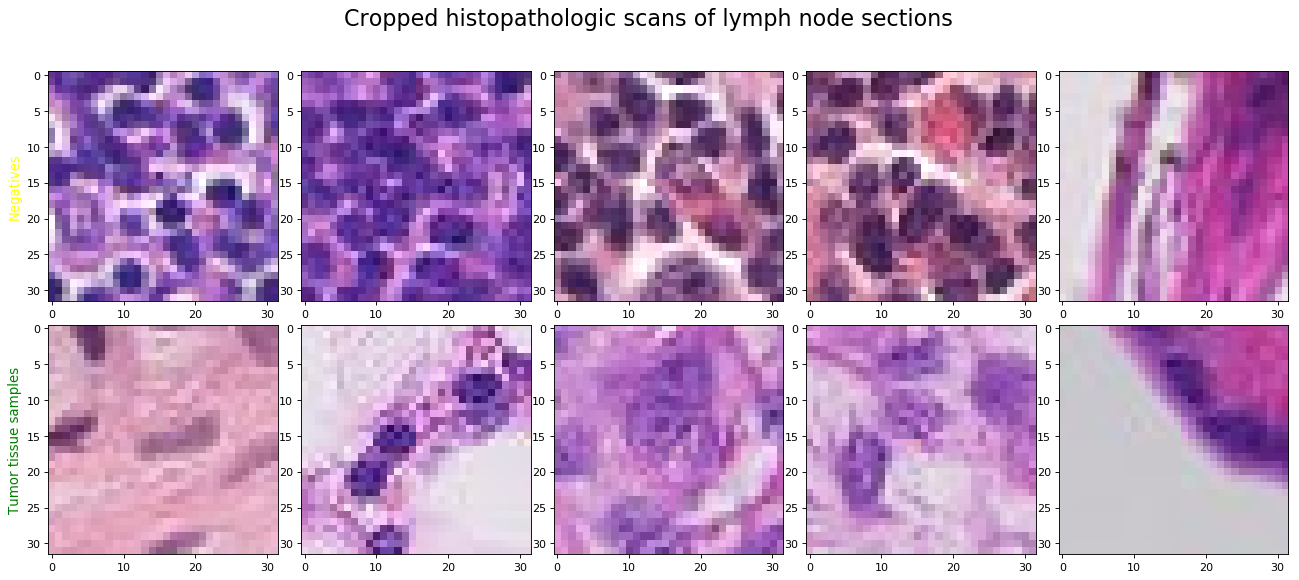

In [9]:
# Now lets look at the cropped image, as the tumors only appear at the center of the images
fig, ax = plt.subplots(nrows=2, ncols=5, dpi=80, figsize=(20, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.1)

fig.suptitle('Cropped histopathologic scans of lymph node sections', fontsize=20)

# Negatives
for i, index in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, index)
    ax[0, i].imshow(read_pre_processed_image(path + '.tif'));
ax[0, 0].set_ylabel(ylabel='Negatives', size='large', color='yellow');

# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    
    path = os.path.join(train_path, idx)
    ax[1, i].imshow(read_pre_processed_image(path + '.tif'));
ax[1, 0].set_ylabel('Tumor tissue samples', size='large', color='green');
plt.savefig('fig2.png')

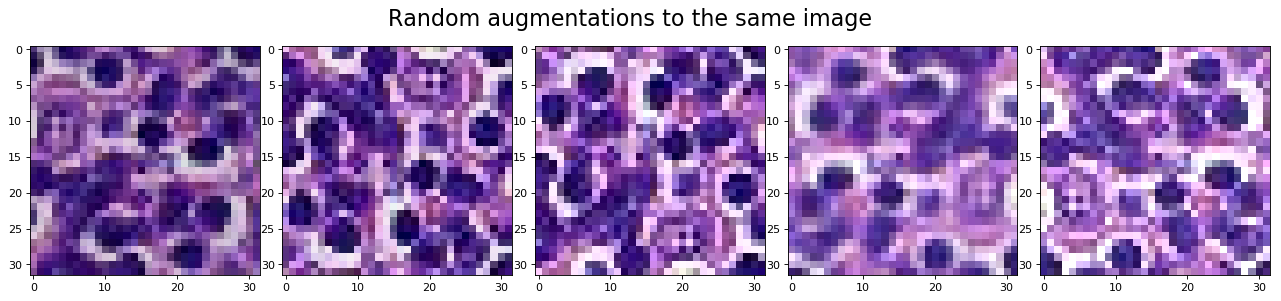

In [11]:
# Lets visualize some of the image variants generated by our pre-processing function
fig, ax = plt.subplots(nrows=1, ncols=5, dpi=80, figsize=(20, 4))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Random augmentations to the same image', fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[j].imshow(read_pre_processed_image(path + '.tif'));
plt.savefig('fig3.png')
        


In [12]:
# Prepare data to be read by the model
shuffled_data = sklearn.utils.shuffle(data)
train = data.set_index('id')
train_names = train.index.values
train_labels = np.asarray(train['label'].values)
train_dict = {'name': train_path+'/'+train_names+'.tif', 'label': train_labels}
train_dataframe = pd.DataFrame(data=train_dict)


In [34]:
# Define a deep convolutional neural net to process the images

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(filepath='weights.hdf5', verbose=1, save_best_only=True)
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu', input_shape=(CROP_SIZE, CROP_SIZE, 3)))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=16, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')) 
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')) 
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=2)) 

model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(Dropout(0.3))
model.add(MaxPooling2D(pool_size=2))

model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'))

model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile model and define training variables
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10
number_of_variants = 5
divide_by = 4

chunk_size = int((len(train_dataframe)/divide_by))
images = np.empty((chunk_size, CROP_SIZE, CROP_SIZE, 3))


In [ ]:
# Load augmented image dataset into memory, chunk by chunk as to not overload our ram, and train the model.
for i in range(divide_by):
    for k in range(number_of_variants):
        print(f"Variant number {k+1}")
        for j in range(chunk_size):
            images[j, :, :, :] = read_pre_processed_image(train_dataframe['name'][(i * chunk_size) + j])
        print(f"Chunk {i+1} loaded.")
        X_train, X_test, y_train, y_test = train_test_split(images,
                                                            train_labels[i*chunk_size:(i+1)*chunk_size],
                                                            test_size=0.1,
                                                            stratify=train_labels[i*chunk_size:(i+1)*chunk_size],
                                                            random_state=123)
        model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=CROP_SIZE, verbose=1, 
                  callbacks=[early_stopping, checkpoint])


In [44]:
# Model 1 had around 80% accuracy
# Lets try other pre-processing and model variants
ORIGINAL_SIZE = 96
CROP_SIZE = 32              # size after cropping
RANDOM_ROTATION = 3         # range (0~180),
RANDOM_SHIFT = 4            # center crop shift in x and y axes  
RANDOM_BRIGHTNESS = 15      # range (0~100), 
RANDOM_CONTRAST = 15        # range (0~100), 
RANDOM_90_DEG_TURN = 1      # (0 or 1), random turn to left or right


def read_just_cropped_image(path):
    rgb_image = read_bgr_to_rgb(path)
    
    start_crop: int = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    return rgb_image[start_crop:end_crop, start_crop:end_crop] / 255


In [ ]:
def read_pre_processed_image2(path):
    rgb_image = read_bgr_to_rgb(path)

    # Rotate
    rotation = random.randint(-RANDOM_ROTATION, RANDOM_ROTATION)
    if RANDOM_90_DEG_TURN == 1:
        rotation += random.randint(-1, 1) * 90
    rotation_matrix = cv2.getRotationMatrix2D(center=(ORIGINAL_SIZE/2, ORIGINAL_SIZE / 2),
                                              angle=rotation, scale=1)
    rgb_image = cv2.warpAffine(src=rgb_image, M=rotation_matrix, dsize=(ORIGINAL_SIZE, ORIGINAL_SIZE))

    # Crop to center, randomize position, and normalize to 0-1 range
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_image = rgb_image[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255

    # Flip
    flip_horizontal = bool(random.getrandbits(1))
    flip_vertical = bool(random.getrandbits(1))

    if flip_horizontal:
        rgb_image = rgb_image[:, ::-1]
    if flip_vertical:
        rgb_image = rgb_image[::-1, :]
        
    # Brightness
    brightness = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100
    rgb_image += brightness
    
    # Contrast
    contrast = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100
    rgb_image *= contrast
    
    # Clip
    rgb_image = np.clip(rgb_image, 0, 1.0)
    
    return rgb_image


In [35]:
# Define model 2
checkpoint = ModelCheckpoint(filepath='weights2.hdf5', verbose=1, save_best_only=True)
model2 = Sequential()
kernel_size = (3, 3)
pool_size = (2, 2)
first_filters = 32
second_filters = 64
third_filters = 128
dropout = 0.3

model2.add(Conv2D(filters=first_filters, kernel_size=kernel_size, padding="same", activation='relu',
                  input_shape=(CROP_SIZE, CROP_SIZE, 3)))
model2.add(Conv2D(filters=first_filters, kernel_size=kernel_size, padding="same", activation='relu'))
model2.add(Conv2D(filters=first_filters, kernel_size=kernel_size, padding="same", activation='relu'))
model2.add(MaxPooling2D(pool_size=pool_size)) 
model2.add(Dropout(dropout))

model2.add(Conv2D(filters=second_filters, kernel_size=kernel_size, padding="same", activation='relu'))
model2.add(Conv2D(filters=second_filters, kernel_size=kernel_size, padding="same", activation='relu'))
model2.add(Conv2D(filters=second_filters, kernel_size=kernel_size, padding="same", activation='relu'))
model2.add(MaxPooling2D(pool_size=pool_size))
model2.add(Dropout(dropout))

model2.add(Conv2D(filters=third_filters, kernel_size=kernel_size, padding="same", activation='relu'))
model2.add(Conv2D(filters=third_filters, kernel_size=kernel_size, padding="same", activation='relu'))
model2.add(Conv2D(filters=third_filters, kernel_size=kernel_size, padding="same", activation='relu'))
model2.add(MaxPooling2D(pool_size=pool_size))
model2.add(Dropout(dropout))

model2.add(Flatten())
model2.add(Dense(256, activation="relu"))
model2.add(Dropout(dropout))
model2.add(Dense(1, activation='sigmoid'))


In [41]:
# Prepare data for training again
shuffled_data = sklearn.utils.shuffle(data)
train = data.set_index('id')
train_names = train.index.values
train_labels = np.asarray(train['label'].values)
train_dict = {'name': train_path+'/'+train_names+'.tif', 'label': train_labels}
train_dataframe = pd.DataFrame(data=train_dict)

In [43]:
# Compile model and set up training
model2.compile(optimizer=Adam(lr=0.00001), loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10
number_of_variants = 15
divide_by = 4

chunk_size = int((len(train_dataframe)/divide_by))
images = np.empty((chunk_size, CROP_SIZE, CROP_SIZE, 3))


NameError: name 'model2' is not defined

In [ ]:
# Train model
for i in range(divide_by):
    for k in range(number_of_variants):
        if k == 0:
            images[j, :, :, :] = read_just_cropped_image(train_dataframe['name'][(i * chunk_size) + j])
        else:
            for j in range(chunk_size):
                images[j, :, :, :] = read_pre_processed_image2(train_dataframe['name'][(i * chunk_size) + j])
        print(f"Chunk {i+1}, Variant: {k+1}")
        X_train, X_test, y_train, y_test = train_test_split(images,
                                                            train_labels[i*chunk_size:(i+1)*chunk_size],
                                                            test_size=0.1,
                                                            stratify=train_labels[i*chunk_size:(i+1)*chunk_size],
                                                            random_state=123)
        model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=CROP_SIZE, verbose=1,
                   callbacks=[early_stopping, checkpoint])


In [23]:
# Model2 has around 85% accuracy, but lets try to use a pre-trained model and imgaug for many more image variants:
shuffled_data = sklearn.utils.shuffle(data)
train = data.set_index('id')
train_names = train.index.values
train_labels = np.asarray(train['label'].values)
train_dict = {'name': train_path+'/'+train_names+'.tif', 'label': train_labels}
train_dataframe = pd.DataFrame(data=train_dict)


In [11]:
# augment images in many more ways than before
def get_seq():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)
    seq = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5),  # horizontally flip 50% of all images
            iaa.Flipud(0.2),  # vertically flip 20% of all images
            sometimes(iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},  # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},  # translate by -20 to +20 percent (per axis)
                rotate=(-10, 10),  # rotate by -45 to +45 degrees
                shear=(-5, 5),  # shear by -16 to +16 degrees
                order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL  # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 3),
                [
                    sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))),  # convert images into their superpixel representation
                    iaa.OneOf([
                        iaa.GaussianBlur((0, 1.0)),  # blur images with a sigma between 0 and 3.0
                        iaa.AverageBlur(k=(3, 5)),  # blur image using local means with kernel sizes between 2 and 7
                        iaa.MedianBlur(k=(3, 5)),  # blur image using local medians with kernel sizes between 2 and 7
                    ]),
                    iaa.Sharpen(alpha=(0, 1.0), lightness=(0.9, 1.1)),  # sharpen images
                    iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # emboss images
                    # search either for all edges or for directed edges,
                    # blend the result with the original image using a blobby mask
                    iaa.SimplexNoiseAlpha(iaa.OneOf([
                        iaa.EdgeDetect(alpha=(0.5, 1.0)),
                        iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                    ])),
                    iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.01*255), per_channel=0.5),  # add gaussian noise to images
                    iaa.OneOf([
                        iaa.Dropout((0.01, 0.05), per_channel=0.5),  # randomly remove up to 10% of the pixels
                        iaa.CoarseDropout((0.01, 0.03), size_percent=(0.01, 0.02), per_channel=0.2),
                    ]),
                    iaa.Invert(0.01, per_channel=True),  # invert color channels
                    iaa.Add((-2, 2), per_channel=0.5),  # change brightness of images (by -10 to 10 of original value)
                    iaa.AddToHueAndSaturation((-1, 1)),  # change hue and saturation
                    # either change the brightness of the whole image (sometimes
                    # per channel) or change the brightness of subareas
                    iaa.OneOf([
                        iaa.Multiply((0.9, 1.1), per_channel=0.5),
                        iaa.FrequencyNoiseAlpha(
                            exponent=(-1, 0),
                            first=iaa.Multiply((0.9, 1.1), per_channel=True),
                            second=iaa.ContrastNormalization((0.9, 1.1))
                        )
                    ]),
                    sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),  # move pixels locally around (with random strengths)
                    sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),  # sometimes move parts of the image around
                    sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                ],
                random_order=True
            )
        ],
        random_order=True
    )
    return seq


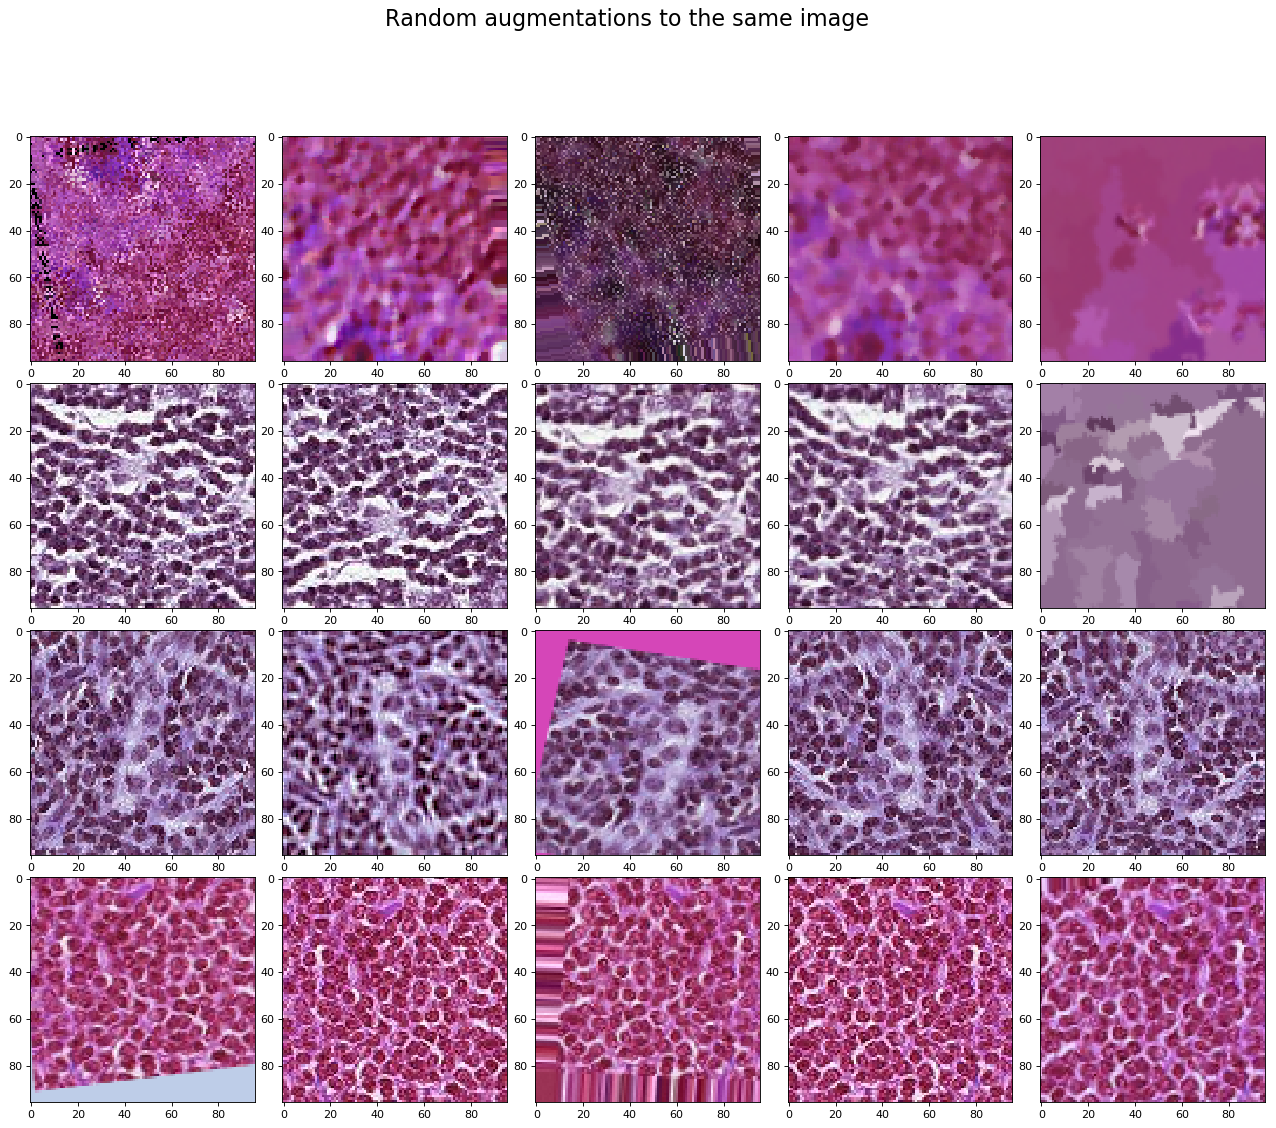

In [17]:
# Lets visualize some of the image variants generated by our pre-processing function
fig, ax = plt.subplots(nrows=4, ncols=5, dpi=80, figsize=(20, 16))
plt.subplots_adjust(wspace=0.1, hspace=0.1)
fig.suptitle('Random augmentations to the same image', fontsize=20)
sequence = get_seq()
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:4]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[i, j].imshow(sequence.augment_image(cv2.imread(path + '.tif')));
plt.savefig('fig4.png')


In [12]:
# define model3 using the pre-trained NASNetMobile model 
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint(filepath='weights3.hdf5', verbose=1, save_best_only=True)
inputs = Input((ORIGINAL_SIZE, ORIGINAL_SIZE, 3))

base_model = NASNetMobile(include_top=False, input_shape=(96, 96, 3))
x = base_model(inputs)
out1 = GlobalMaxPooling2D()(x)
out2 = GlobalAveragePooling2D()(x)
out3 = Flatten()(x)
out = Concatenate(axis=-1)([out1, out2, out3])
out = Dropout(0.5)(out)
out = Dense(1, activation='sigmoid', name="output")(out)
model3 = Model(inputs, out)


In [24]:
# Compile and prepare to train
# model3.load_weights("weights3.hdf5") # Uncomment this to load pre-trained model
model3.compile(optimizer=Adam(lr=0.000001), loss='binary_crossentropy', metrics=['accuracy'])

epochs = 10
number_of_variants = 10
divide_by = 8
batch_size = 64

chunk_size = int((len(train_dataframe)/divide_by))
images = np.empty((chunk_size, ORIGINAL_SIZE, ORIGINAL_SIZE, 3))

sequence = get_seq()

In [ ]:
# Train model
for i in range(divide_by):
    for k in range(number_of_variants):
        if k % 2 == 0 and k:  # I found this to be the best way to make the model learn, especially at later stages
            for j in range(chunk_size):
                images[j, :, :, :] = cv2.imread(train_dataframe['name'][(i * chunk_size) + j])
        else:
            for j in range(chunk_size):
                images[j, :, :, :] = sequence.augment_image(cv2.imread(train_dataframe['name'][i * chunk_size + j]))
        print(f"Chunk {i+1}, Variant: {k+1}")
        X_train, X_test, y_train, y_test = train_test_split(images,
                                                            train_labels[i*chunk_size:(i+1)*chunk_size],
                                                            test_size=0.1,
                                                            stratify=train_labels[i*chunk_size:(i+1)*chunk_size],
                                                            random_state=0)
        model3.fit(X_train, y_train, validation_data=(X_test, y_test), 
                             batch_size=batch_size, epochs=epochs,
                             verbose=1, callbacks=[checkpoint])


0

In [14]:
# create test dataframe
test_names = []
for f in os.listdir(test_path):
    test_names.append(test_path + "/" + f)
test_dataframe = pd.DataFrame(np.asarray(test_names), columns=['name'])


In [15]:
# Read test images
test_images = np.empty((len(test_dataframe), ORIGINAL_SIZE, ORIGINAL_SIZE, 3))
for i in range(len(test_dataframe)):
            test_images[i, :, :, :] = cv2.imread(test_dataframe['name'][i])


In [16]:
# Make predictions
predictions = model3.predict(test_images)


In [17]:
# Create a dictionary with ids and predictions
submission = {}
for i in range(len(predictions)):
    submission.update({test_dataframe['name'][i]: predictions[i][0]})


In [25]:
print(submission.get('Histopathologic Cancer Detection/test/0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5.tif'))

0.002342682


In [ ]:
# Read template submission and reorder predictions to the same order as template
sample_submission = pd.read_csv('Histopathologic Cancer Detection/sample_submission.csv')
sample_submission = list(sample_submission.id)

predictions_correct_order = [submission['Histopathologic Cancer Detection/test/' + id + '.tif'] for id in sample_submission]
predictions_correct_order[0]


submission_dataframe = pd.DataFrame({'id':sample_submission, 'label':predictions_correct_order})
submission_dataframe.shape


In [21]:
submission_dataframe.to_csv('submission.csv', header=True, index=False)
